In [20]:
from pathlib import Path
import pandas as pd
import woodsort.nwb as nwb 
import pynapple as nap
import spikeinterface.full as si
import warnings
import neuroconv.tools.spikeinterface as nc

In [25]:
### SPECIFY PATHS ### 

data_path = Path('/home/avadher/Data/')
session_name = 'H7113-250604'
meta_name = 'H7100_metadata.xlsx'
analyzer_name = session_name + '_analyzer_mountainsort5'
nwb_path = data_path / 'NWB' / session_name

session_path = list(data_path.rglob(session_name))[0]

# Ignore annoying warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [26]:
### LOAD DATA ###

metadata = nwb.io.read_metadata_excel(data_path / meta_name, session_name, print_output=True)
start_time = nwb.io.get_start_time(session_path)

# load tracking 
tracking = pd.read_csv(session_path / 'TrackingProcessed.csv',index_col=0, header=0)
pos = nap.TsdFrame(tracking[["x", "y"]])
hd = nap.Tsd(tracking['hd'])
epochs = pd.read_csv(session_path / 'EpochTimestamps.csv', header=0)

# get probe mapping
probe_mapping = pd.read_csv(session_path / 'ChannelMapping.csv',index_col=0, header=0)

# add probe 



{'epoch': {'1': 'wake', '2': 'sleep', '3': 'wake_cue_rot'},
 'file': {'experiment_description': 'Reorientation in the head-direction system',
          'experimenter': 'Narayanan, Trisha',
          'institution': 'University of Edinburgh',
          'lab': 'Wood/Dudchenko lab',
          'name': 'H7113-250604',
          'protocol': 'day1',
          'session_description': 'Cue rotations (45, 90, 135, 180 deg)'},
 'probe': [{'description': '2x32-channels, 25 um channel spacing, implanted at 10 deg angle. '
                           'Channels sorted top to bottom of shank.',
            'id': 1,
            'location': 'left postsubiculum',
            'nshanks': 2,
            'step': 25,
            'type': 'Cambridge Neurotech H7 probe'}],
 'subject': {'dob': 250228, 'genotype': 'WT', 'line': 'Fmr1', 'sex': 'M', 'stock_id': 1906344}}

Start time from sync_messages.txt: 2025-06-04 14:46:12.720000+01:00


In [27]:
### NWB ### 

#Create NWB file
nwbfile = nwb.convert.create_nwb_file(metadata, start_time)

# Add units
nwbfile = nwb.convert.add_units_spikeinterface(nwbfile, session_path / analyzer_name)

# Add tracking
nwbfile = nwb.convert.add_tracking(nwbfile, pos, hd)

# Add epochs
nwbfile = nwb.convert.add_epochs(nwbfile, epochs, metadata)

# Save NWB file
nwbfile = nwb.convert.save_nwb_file(nwbfile, nwb_path, session_name)

# Load to check
data = nwb.convert.load_nwb_file(nwb_path, session_name)



Creating NWB file and adding metadata...
Adding SpikeInterface units and metrics to the NWB file...
Adding tracking to NWB file...
Adding epochs to NWB file...
Saving NWB file...


OSError: Unable to synchronously create file (unable to truncate a file which is already open)

In [4]:

print(data['units']["extremum_channel"])
wf = data.nwb.units['waveform_mean'].data[:]

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for u in range(wf.shape[0]):
    plt.plot(wf[u], color="black", alpha=0.15)

plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("All units – mean waveform (single channel per unit)")
plt.tight_layout()
plt.show()


NameError: name 'data' is not defined

In [9]:
sorting_analyzer = si.load_sorting_analyzer(session_path / analyzer_name)
nwbfile = nc.add_recording_metadata_to_nwbfile(sorting_analyzer.recording, nwbfile)


AttributeError: 'NoneType' object has no attribute 'devices'

['CH1' 'CH2' 'CH3' 'CH4' 'CH5' 'CH6' 'CH7' 'CH8' 'CH9' 'CH10' 'CH11'
 'CH12' 'CH13' 'CH14' 'CH15' 'CH16' 'CH17' 'CH19' 'CH20' 'CH21' 'CH22'
 'CH23' 'CH24' 'CH25' 'CH26' 'CH27' 'CH28' 'CH29' 'CH30' 'CH31' 'CH32'
 'CH63' 'CH18' 'CH33' 'CH34' 'CH35' 'CH36' 'CH37' 'CH38' 'CH39' 'CH40'
 'CH41' 'CH42' 'CH43' 'CH44' 'CH45' 'CH46' 'CH47' 'CH48' 'CH49' 'CH50'
 'CH51' 'CH52' 'CH53' 'CH54' 'CH55' 'CH56' 'CH57' 'CH58' 'CH59' 'CH60'
 'CH61' 'CH62' 'CH64']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_backend_options', '_get_zarr_root', '_recording', '_save_or_select_or_merge_or_split', '_temporary_recording', 'are_units_mergeable', 'channel_ids', 'channel_ids_to_indices', 'compute', 'compute_one_extensi

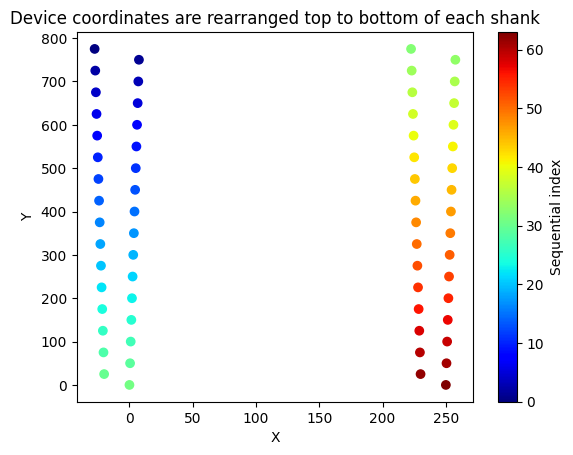

In [33]:
import numpy as np
import spikeinterface.full as si
from neuroconv.tools.spikeinterface import add_sorting_to_nwbfile, add_recording_metadata_to_nwbfile
import pandas as pd
import json
from pprint import pprint 

sorting_analyzer = si.load_sorting_analyzer(session_path / analyzer_name)
print(sorting_analyzer.channel_ids)
print(dir(sorting_analyzer))

mapping = dict(zip(sorting_analyzer.get_probe().device_channel_indices, sorting_analyzer.get_probe().contact_ids))
coors = sorting_analyzer.get_probe().contact_positions
order = sorted(mapping, key=lambda k: int(mapping[k]))
coors = coors[order]


plt.scatter(coors[:, 0], coors[:, 1], c=np.arange(len(coors)), cmap='jet')
plt.colorbar(label="Sequential index")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Device coordinates are rearranged top to bottom of each shank")
plt.show()

Creating NWB file and adding metadata...
Adding SpikeInterface units and metrics to the NWB file...
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 63 18 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 64]


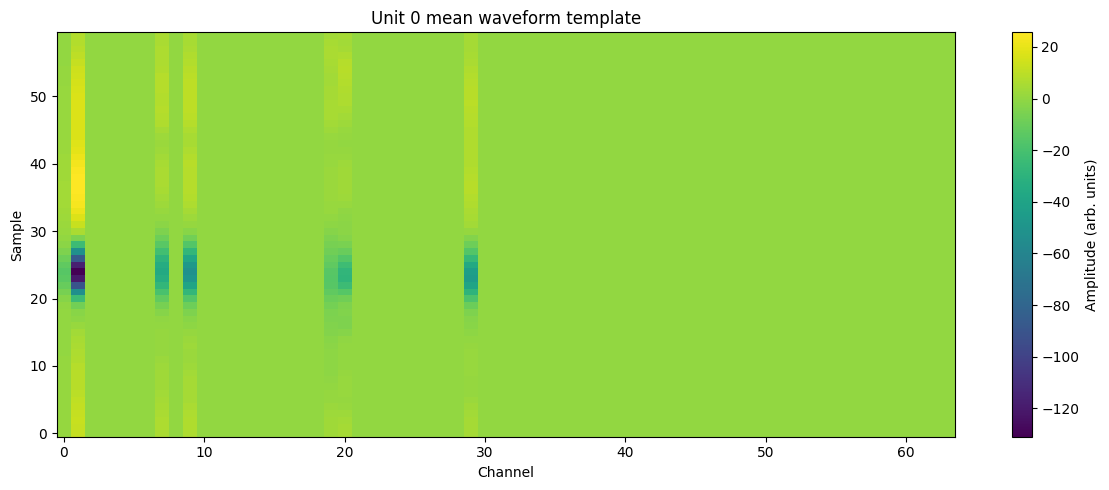

In [35]:

import numpy as np
import spikeinterface.full as si
from neuroconv.tools.spikeinterface import add_sorting_to_nwbfile, add_recording_metadata_to_nwbfile
import pandas as pd
import json
import matplotlib.pyplot as plt

nwbfile = nwb.convert.create_nwb_file(metadata, start_time)

def add_units_spikeinterface(nwbfile, analyzer_path, curation_path=None):

    print("Adding SpikeInterface units and metrics to the NWB file...")
    si.set_global_job_kwargs(n_jobs=12)
    sorting_analyzer = si.load_sorting_analyzer(analyzer_path)


    # default curation path
    if curation_path is None:
        curation_path = analyzer_path / "spikeinterface_gui/curation_data.json"

    # apply manual curation
    if not curation_path.exists():
        raise FileNotFoundError(
            f"Curation file not found at {curation_path}. "
            "Run SpikeInterface GUI curation first or provide a valid curation_path."
        )

    with open(curation_path, "r") as f:
        curation_dict = json.load(f)

    sorting_analyzer = si.apply_curation(sorting_analyzer, curation_dict, merging_mode='soft')
    
    # get stuff from analyzer and sorting
    add_sorting_to_nwbfile(sorting_analyzer.sorting, nwbfile)

    # add recording info


    # quality metrics
    quality_metrics = sorting_analyzer.get_extension('quality_metrics').get_data()

    # template metrics
    template_metrics = sorting_analyzer.get_extension('template_metrics').get_data()

    # unit locations
    probe_locations = sorting_analyzer.get_extension("unit_locations").get_data()

    # waveforms
    waveforms = sorting_analyzer.get_extension("templates").get_data()
    waveforms = np.asarray(waveforms, dtype=np.float32)

    probe_locations_df = pd.DataFrame()
    for coord, data in zip(["x", "y", "z"], probe_locations.T, strict=True):
        probe_locations_df[f"coord_est_{coord}"] = data

    # and which channel the extremal template (template with max amp) is on
    # --- max channel per unit (0-based index) ---

    ext_map = si.get_template_extremum_channel(
        sorting_analyzer, peak_sign="neg", outputs="id"
    )  # dict: unit_id -> "CH##"

    extremum_channel = np.array(
        [int(str(ext_map[uid]).replace("CH", "")) for uid in ext_map],
        dtype=int
    )

    probe_locations_df["extremum_channel"] = extremum_channel

    # now pick only the biggest waveform based on extremum channel

    channel_ids = np.array(
        [int(ch.replace("CH", "")) for ch in sorting_analyzer.channel_ids],
        dtype=int
    )

    chan_id_to_index = {cid: i for i, cid in enumerate(channel_ids)}
    extremum_chan_idx = np.array(
        [chan_id_to_index[cid] for cid in extremum_channel],
        dtype=int
    )

    print(channel_ids)

    all_unit_metadata = pd.concat(
        [
            probe_locations_df.reset_index(drop=True),
            quality_metrics.reset_index(drop=True),
            template_metrics.reset_index(drop=True),
        ],
        axis=1,
    )

    # here, we add all that to the nwbfile
    for column_name, unit_data in all_unit_metadata.items():

        # force numeric columns to float (pd.NA -> np.nan)
        if unit_data.dtype == "object":
            unit_data = pd.to_numeric(unit_data, errors="coerce")

        nwbfile.units.add_column(
            name=column_name,
            data=unit_data.to_numpy(),
            description=f"{column_name}, computed using spikeinterface.",
        )

    nwbfile.units.add_column(
        name="waveform_mean",
        data=waveforms,
        description="Mean waveform template from SpikeInterface (sample x channel).",
    )

    return nwbfile

add_units_spikeinterface(nwbfile, session_path / analyzer_name, curation_path=None)


wf = nwbfile.units['waveform_mean'][1]



import matplotlib.pyplot as plt

# Grab unit 0 template from NWB

plt.figure(figsize=(12, 5))
im = plt.imshow(wf, aspect="auto", origin="lower")
plt.xlabel("Channel")
plt.ylabel("Sample")
plt.title("Unit 0 mean waveform template")
plt.colorbar(im, label="Amplitude (arb. units)")
plt.tight_layout()
plt.show()
